In [5]:
!pip install opencv-python-headless
!pip install path
!pip install pydicom
!pip install keras-tuner
!pip install scikeras
!pip install seaborn

     |████████████████████████████████| 292 kB 34.1 MB/s            


In [15]:
! pip install -q kaggle

In [9]:
import warnings, random, os, pydicom, cv2, glob, re
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, MobileNetV2, VGG19

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, GlobalAveragePooling2D, MaxPooling2D, Conv2D, AveragePooling2D

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

from pydicom.pixel_data_handlers.util import apply_voi_lut

# tf.config.run_functions_eagerly(True)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


In [16]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c rsna-miccai-brain-tumor-radiogenomic-classification
! mkdir train
! unzip rsna-miccai-brain-tumor-radiogenomic-classification.zip -d train

 44%|█████████████████▏                     | 5.40G/12.3G [00:27<00:34, 217MB/s]

In [19]:
mri_types = ['FLAIR','T1w','T1wCE','T2w']
SIZE = 256
NUM_IMAGES = 64

In [20]:
def load_dicom_image(path, img_size=SIZE):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = cv2.resize(data, (img_size, img_size))
    return data

In [21]:
load_dicom_image('./train/train/00000/FLAIR/Image-154.dcm')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [22]:
def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR"):
    files = sorted(glob.glob(f"./train/train/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)     
    return img3d

In [24]:
df_labels = pd.read_csv('./train/train_labels.csv', dtype={0:'object', 1:'int8'})
df_labels.head()

,BraTS21ID,MGMT_value
0,00000,1
1,00002,1
2,00003,0
3,00005,1
4,00006,1


In [25]:
df_labels_train_val, df_labels_test = train_test_split(df_labels, test_size=0.2, random_state=123)
df_labels_train, df_labels_val = train_test_split(df_labels_train_val, test_size=0.2, random_state=123)

In [26]:
def generator_train():
    for i in range(df_labels_train.shape[0]):
        x = load_dicom_images_3d(df_labels_train['BraTS21ID'].iloc[i])
        y = df_labels_train['MGMT_value'].iloc[i]
        yield x, y
def generator_val():
    for i in range(df_labels_val.shape[0]):
        x = load_dicom_images_3d(df_labels_val['BraTS21ID'].iloc[i])
        y = df_labels_val['MGMT_value'].iloc[i]
        yield x, y
def generator_test():
    for i in range(df_labels_test.shape[0]):
        x = load_dicom_images_3d(df_labels_test['BraTS21ID'].iloc[i])
        y = df_labels_test['MGMT_value'].iloc[i]
        yield x, y

In [27]:
ds_train = tf.data.Dataset.from_generator(generator_train, args=[], 
                                          output_types=(tf.int16, tf.int8), 
                                          output_shapes = (((SIZE, SIZE, NUM_IMAGES), ())))
ds_val = tf.data.Dataset.from_generator(generator_val, args=[], 
                                          output_types=(tf.int16, tf.int8), 
                                          output_shapes = (((SIZE, SIZE, NUM_IMAGES), ())))
ds_test = tf.data.Dataset.from_generator(generator_test, args=[], 
                                          output_types=(tf.int16, tf.int8), 
                                          output_shapes = (((SIZE, SIZE, NUM_IMAGES), ())))
ds_train = ds_train.batch(8)
ds_val = ds_val.batch(8)
ds_test = ds_test.batch(8)

In [29]:
from tensorflow.keras.applications import InceptionV3
base_model = InceptionV3(
    input_shape=(256, 256, 1),
    include_top=False,
    weights=None,
)

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [32]:
def crear_clasificador_propio(n_lay_convs = 3, fil1 = 16, fil2 = 32, fil3 = 64, ks=3, s=2, 
                              n_lay_dense = 2, nn1 = 32, nn2 = 16, activacion = 'relu'):
    output = 1
    #filtros = [fil1, fil2, fil3]
    neurons = [nn1, nn2]
    clasificador = Sequential(name="ClasificadorPropio")
    clasificador.add(Input(shape=(SIZE, SIZE, NUM_IMAGES)))
    # for i in range(n_lay_convs):
        # clasificador.add(Conv2D(filters=filtros[i], kernel_size=ks, strides=s, padding="same", activation=activacion))
    base_model = InceptionV3(
    input_shape=(SIZE, SIZE, NUM_IMAGES),
    include_top=False,
    weights=None)
    clasificador.add(base_model) 
    clasificador.add(GlobalAveragePooling2D()) 
    for i in range(n_lay_dense):
        clasificador.add(Dense(neurons[i], activation=activacion))
    clasificador.add(Dense(output, activation='sigmoid', name= 'Capa_Salida'))
    clasificador.compile(loss='binary_crossentropy',
                          optimizer='adam', 
                          metrics=["accuracy"],
                          run_eagerly=True)
    return clasificador

In [33]:
clasificador_propio = crear_clasificador_propio()
clasificador_propio.summary()

Model: "ClasificadorPropio"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21820352  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                65568     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
Capa_Salida (Dense)          (None, 1)                 17        
Total params: 21,886,465
Trainable params: 21,852,033
Non-trainable params: 34,432
_________________________________________________________________


In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)

In [35]:
with tf.device('/device:GPU:0'): 
    clasificador_propio.fit(
        ds_train,
        validation_data=ds_val,
        epochs=10,
        callbacks=[early_stopping]
    )

Epoch 1/10
47/47 [==============================] - 144s 3s/step - loss: 0.7493 - accuracy: 0.5134 - val_loss: 0.6870 - val_accuracy: 0.5745
Epoch 2/10
47/47 [==============================] - 84s 2s/step - loss: 0.6960 - accuracy: 0.5187 - val_loss: 0.6862 - val_accuracy: 0.5745
Epoch 3/10
47/47 [==============================] - 83s 2s/step - loss: 0.6893 - accuracy: 0.5561 - val_loss: 0.6827 - val_accuracy: 0.5745
Epoch 4/10
47/47 [==============================] - 82s 2s/step - loss: 0.6877 - accuracy: 0.5481 - val_loss: 0.6848 - val_accuracy: 0.5745
Epoch 5/10
47/47 [==============================] - 83s 2s/step - loss: 0.6785 - accuracy: 0.5829 - val_loss: 0.6822 - val_accuracy: 0.5745
Epoch 6/10
47/47 [==============================] - 83s 2s/step - loss: 0.6504 - accuracy: 0.6471 - val_loss: 0.7785 - val_accuracy: 0.4255
Epoch 7/10
47/47 [==============================] - 83s 2s/step - loss: 0.6566 - accuracy: 0.5989 - val_loss: 0.7291 - val_accuracy: 0.4255
Epoch 8/10
47/47 [=

In [38]:
!mkdir models

In [40]:
# clasificador_propio.save('./models/clasificador_propio_base.h5')
clasificador_propio = tf.keras.models.load_model('./models/clasificador_propio_base.h5')

In [41]:
def darF1Score(model, dataset, print_report=False):
    y_true, y_pred = [], []
    for x, y in dataset:
        y_true.extend(y.numpy().tolist())
        y_pred.extend(model.predict(x, verbose=0).round().astype(int).tolist())
    if print_report:
        print(classification_report(y_true, y_pred))
    f1 = f1_score(y_true, y_pred, average='weighted')
    return y_true, y_pred, f1

In [42]:
y_true, y_pred, f1 = darF1Score(clasificador_propio, ds_val, print_report=True)

              precision    recall  f1-score   support

           0       0.42      0.93      0.58        40
           1       0.50      0.06      0.10        54

    accuracy                           0.43        94
   macro avg       0.46      0.49      0.34        94
weighted avg       0.47      0.43      0.30        94



In [43]:
def get_params(params_grid):
    params = {}
    for key, list_values in params_grid.items():
        params[key] = random.choice(list_values)
    return params

In [44]:
def search_model(create_model, params_grid, ds_train, ds_val, n_iter=25):
    params_best_model, best_f1_score = None, 0
    for i in range(n_iter):
        params = get_params(params_grid)
        print('Training inter {} for params:\n'.format(i+1), params)
        model = create_model(**params)
        with tf.device('/device:GPU:0'): 
            model.fit(
                ds_train,
                validation_data=ds_val,
                epochs=25,
                callbacks=[early_stopping]
            )
        f1_score = darF1Score(model, ds_val)[2]
        print('F1-score for iter {}: {}'.format(i+1, f1_score))
        if f1_score > best_f1_score:
            params_best_model = params
            best_f1_score = f1_score
        print('Best F1-score so far:\n', best_f1_score)
        print('Best params so far:\n', params_best_model)
    return params_best_model, best_f1_score

In [45]:
params_grid = {  
    'n_lay_convs': [1, 2, 3],
    'fil1': [20, 16, 12],
    'fil2': [40, 32, 24],
    'fil3': [80, 64, 48],
    'ks': [3, 5, 7],
    's': [2, 3, 4],
    'n_lay_dense': [1, 2],
    'nn1': [40, 32, 24],
    'nn2': [20, 16, 12],
    'activacion': ['relu','sigmoid']
}

params_best_model_propio, best_f1_score_propio = search_model(crear_clasificador_propio, params_grid, ds_train, ds_val)

Training inter 1 for params:
 {'n_lay_convs': 3, 'fil1': 20, 'fil2': 32, 'fil3': 48, 'ks': 5, 's': 2, 'n_lay_dense': 1, 'nn1': 24, 'nn2': 20, 'activacion': 'relu'}
Epoch 1/25
47/47 [==============================] - 85s 2s/step - loss: 0.8145 - accuracy: 0.4947 - val_loss: 0.7786 - val_accuracy: 0.4255
Epoch 2/25
47/47 [==============================] - 86s 2s/step - loss: 0.6939 - accuracy: 0.5080 - val_loss: 0.8041 - val_accuracy: 0.4255
Epoch 3/25
47/47 [==============================] - 86s 2s/step - loss: 0.7006 - accuracy: 0.5374 - val_loss: 0.7610 - val_accuracy: 0.4255
Epoch 4/25
47/47 [==============================] - 87s 2s/step - loss: 0.6907 - accuracy: 0.5080 - val_loss: 0.6926 - val_accuracy: 0.5745
Epoch 5/25
47/47 [==============================] - 87s 2s/step - loss: 0.6642 - accuracy: 0.5348 - val_loss: 0.6935 - val_accuracy: 0.4255
Epoch 6/25
47/47 [==============================] - 87s 2s/step - loss: 0.6226 - accuracy: 0.6524 - val_loss: 0.6948 - val_accuracy: 0.4

In [46]:
print('El mejor modelo encontrado por la búsqueda de hiperparámetros obtuvo un F1-score de {} con parámetros \n{}'.format(best_f1_score_propio, params_best_model_propio))

El mejor modelo encontrado por la búsqueda de hiperparámetros obtuvo un F1-score de 0.4354911724762336 con parámetros 
{'n_lay_convs': 2, 'fil1': 20, 'fil2': 32, 'fil3': 48, 'ks': 3, 's': 4, 'n_lay_dense': 2, 'nn1': 32, 'nn2': 12, 'activacion': 'sigmoid'}


In [47]:
params_best_model_propio = {'n_lay_convs': 3, 'fil1': 12, 'fil2': 24, 'fil3': 80, 'ks': 5, 's': 2, 'n_lay_dense': 1, 'nn1': 40, 'nn2': 16, 'activacion': 'relu'}
best_clasificador_propio = crear_clasificador_propio(**params_best_model_propio)
best_clasificador_propio.summary()

Model: "ClasificadorPropio"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21820352  
_________________________________________________________________
global_average_pooling2d_26  (None, 2048)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 40)                81960     
_________________________________________________________________
Capa_Salida (Dense)          (None, 1)                 41        
Total params: 21,902,353
Trainable params: 21,867,921
Non-trainable params: 34,432
_________________________________________________________________


In [50]:
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
with tf.device('/device:GPU:0'): 
    best_clasificador_propio.fit(
        ds_train.concatenate(ds_val),
        epochs=10,
        callbacks=[early_stopping]
    )

Epoch 1/10
59/59 [==============================] - 111s 2s/step - loss: 0.6926 - accuracy: 0.5214
Epoch 2/10
59/59 [==============================] - 112s 2s/step - loss: 0.6926 - accuracy: 0.5214
Epoch 3/10
59/59 [==============================] - 91s 2s/step - loss: 0.6925 - accuracy: 0.5214
Epoch 4/10
59/59 [==============================] - 121s 2s/step - loss: 0.6925 - accuracy: 0.5214
Epoch 5/10
59/59 [==============================] - 143s 2s/step - loss: 0.6924 - accuracy: 0.5214
Epoch 6/10
59/59 [==============================] - 144s 2s/step - loss: 0.6924 - accuracy: 0.5214
Epoch 7/10
59/59 [==============================] - 145s 2s/step - loss: 0.6924 - accuracy: 0.5214
Epoch 8/10
59/59 [==============================] - 143s 2s/step - loss: 0.6924 - accuracy: 0.5214
Epoch 9/10
59/59 [==============================] - 145s 2s/step - loss: 0.6923 - accuracy: 0.5214
Epoch 10/10
59/59 [==============================] - 144s 2s/step - loss: 0.6923 - accuracy: 0.5214


In [51]:
best_clasificador_propio.save('./models/best_clasificador_propio.h5')

In [52]:
best_clasificador_propio = tf.keras.models.load_model('./models/best_clasificador_propio.h5')

--------------------------------------------------------
Reporte para el mejor modelo propio sobre datos de entrenamiento
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       184
           1       0.51      1.00      0.67       190

    accuracy                           0.51       374
   macro avg       0.25      0.50      0.34       374
weighted avg       0.26      0.51      0.34       374

--------------------------------------------------------
Reporte para el mejor modelo propio sobre datos de validación
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.57      1.00      0.73        54

    accuracy                           0.57        94
   macro avg       0.29      0.50      0.36        94
weighted avg       0.33      0.57      0.42        94

--------------------------------------------------------
Reporte para el mejor modelo propio sobre datos 

Text(54.260000000000005, 0.5, 'Etiquetas predichas')

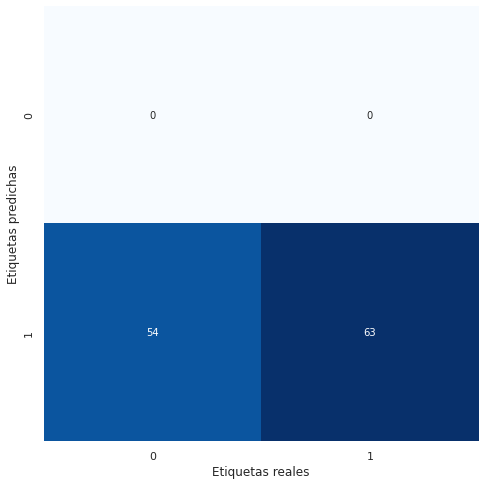

In [53]:
print('--------------------------------------------------------')
print('Reporte para el mejor modelo propio sobre datos de entrenamiento')
y_true, y_pred, f1 = darF1Score(best_clasificador_propio, ds_train, print_report=True)
print('--------------------------------------------------------')
print('Reporte para el mejor modelo propio sobre datos de validación')
y_true, y_pred, f1 = darF1Score(best_clasificador_propio, ds_val, print_report=True)
print('--------------------------------------------------------')
print('Reporte para el mejor modelo propio sobre datos de prueba')
y_true, y_pred, f1 = darF1Score(best_clasificador_propio, ds_test, print_report=True)
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Etiquetas reales')
plt.ylabel('Etiquetas predichas')